#### ADS Data Cleaning<br>
[Aerial Detection Survey](https://www.fs.usda.gov/foresthealth/applied-sciences/mapping-reporting/detection-surveys.shtml)
###### Detection surveys are the primary method of collecting data on the health of treed areas affected by insects and diseases. Aerial and ground surveys using applications like Digital Mobile Sketch Mapping (DMSM) and Southern Pine Beetle (SPB) Collector Map are conducted annually. Geospatial data collected with these systems is stored in a National Insect and Disease Survey (IDS) database.

In [4]:
# import modules
import pandas as pd
import geopandas as gpd
import os

# import modules
import ee
import geemap
import geopandas as gpd
import rasterio as ras
import numpy as np
import json
import requests
import os
from datetime import datetime
import glob
from zipfile import ZipFile
from zipfile import BadZipfile
from shapely.geometry import box
from shapely.geometry import Polygon
from osgeo import gdal, ogr, osr
from matplotlib import pyplot as plt
import rasterio as ras

# initialization and authentication
#ee.Authenticate()
ee.Initialize()

In [2]:
#ee.Authenticate()

<Axes: >

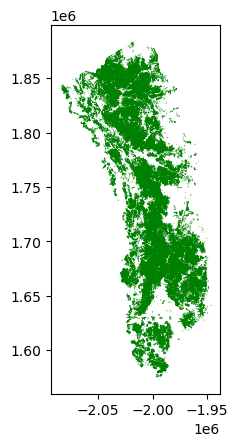

In [3]:
# open ADS an Southern Sierra Nevada (SSN) 
ads_df = gpd.read_file('./input/Damage_Area_All_years.shp')
# SN shape
sn_shp = gpd.read_file('./input/Southern_Sierra.shp')
ads_df.plot(color='green')

In [4]:
ads_df.columns

Index(['OBJECTID', 'DAMAGE_ARE', 'CREATED_DA', 'MODIFIED_D', 'FEATURE_US',
       'OBSERVATIO', 'REGION_ID', 'LABEL', 'HOST_CODE', 'HOST', 'HOST_GROUP',
       'HOST_GRO_1', 'DCA_CODE', 'DCA_COMMON', 'DAMAGE_TYP', 'DAMAGE_T_1',
       'PERCENT_AF', 'PERCENT__1', 'PERCENT_MI', 'PERCENT_MA', 'PERCENT__2',
       'NOTES', 'OBSERVAT_1', 'COLLECTION', 'SNAPGRID_R', 'SNAPGRID_C',
       'AREA_TYPE', 'ACRES', 'STATUS', 'SURVEY_YEA', 'LEGACY_SEV',
       'LEGACY_S_1', 'LEGACY_PAT', 'LEGACY_P_1', 'LEGACY_TPA', 'LEGACY_NO_',
       'LEGACY_FOR', 'LEGACY_F_1', 'GRP', 'OBSERVAT_2', 'IDS_DATA_S',
       'DATA_SOURC', 'US_AREA', 'SHAPE_Leng', 'SHAPE_Area', 'geometry'],
      dtype='object')

##### Selecting data for SSN after 2016 and droping all NA data and Subset a random sapmle from the dataset

In [16]:
# cleanup the data frame
ads_complete = ads_df[['OBJECTID','HOST_CODE',
                 'HOST', 'DCA_CODE', 'DCA_COMMON',
                 'DAMAGE_TYP','DAMAGE_T_1', 'PERCENT_AF',
                 'PERCENT__1', 'ACRES', 'SURVEY_YEA','geometry']]
ads_complete.head()
# year filter
ads_dfyear = ads_complete[ads_complete.SURVEY_YEA >= 2020]
# copy data frame
ads_df_full = ads_dfyear.copy()
# replace -1 from nans 
ads_df_full.replace(-1, float('nan'), inplace=True)
# drop nas
ads_df_full = ads_df_full.dropna()


# severe polygons on after 2016 filter
ads_vs = ads_df_full[ads_df_full.PERCENT_AF == 5]
print(len(ads_vs), ' very severe incidents')
# very light filter 
ads_vl = ads_df_full[ads_df_full.PERCENT_AF == 1]
print(len(ads_vl), 'very light incidents')
# severe filter
ads_s = ads_df_full[ads_df_full.PERCENT_AF == 4]
print(len(ads_s), 'severe incidents')

# Moderate filter
ads_m = ads_df_full[ads_df_full.PERCENT_AF == 3]
print(len(ads_m), 'moderate incidents')
# Light filter
ads_l = ads_df_full[ads_df_full.PERCENT_AF == 2]
print(len(ads_l), 'light incidents')


3  very severe incidents
254 very light incidents
172 severe incidents
613 moderate incidents
776 light incidents


In [52]:
# taking random sample ferom each mortality class
seed = 42
# vs sample
vs_sample = ads_vs.sample(n=200, random_state=seed)
print(f'sample size very severe {len(vs_sample)} ')
print(vs_sample[['HOST', 'PERCENT_AF', 'PERCENT__1']].head())

sample size very severe 200 
                     HOST  PERCENT_AF          PERCENT__1
42350      ponderosa pine         5.0  Very Severe (>50%)
39602      ponderosa pine         5.0  Very Severe (>50%)
38824           white fir         5.0  Very Severe (>50%)
41827  California red fir         5.0  Very Severe (>50%)
38890  California red fir         5.0  Very Severe (>50%)


In [53]:
# taking random sample ferom each mortality class
seed = 42
# severe sample
s_sample = ads_s.sample(n=200, random_state=seed)
print(f'sample size severe {len(s_sample)} ')
print(s_sample[['HOST', 'PERCENT_AF', 'PERCENT__1']].head())

sample size severe 200 
                     HOST  PERCENT_AF       PERCENT__1
40850  California red fir         4.0  Severe (30-50%)
40148           white fir         4.0  Severe (30-50%)
39895  California red fir         4.0  Severe (30-50%)
40633  California red fir         4.0  Severe (30-50%)
40075  California red fir         4.0  Severe (30-50%)


In [54]:
# taking random sample ferom each mortality class
seed = 42
# moderate sample
m_sample = ads_m.sample(n=200, random_state=seed)
print(f'sample size severe {len(m_sample)} ')
print(m_sample[['HOST', 'PERCENT_AF', 'PERCENT__1']].head())

sample size severe 200 
                     HOST  PERCENT_AF         PERCENT__1
45205           white fir         3.0  Moderate (11-29%)
39970      lodgepole pine         3.0  Moderate (11-29%)
44003  California red fir         3.0  Moderate (11-29%)
39331        Jeffrey pine         3.0  Moderate (11-29%)
43566    All tree species         3.0  Moderate (11-29%)


In [55]:
# taking random sample ferom each mortality class
seed = 42
# light sample
l_sample = ads_l.sample(n=200, random_state=seed)
print(f'sample size severe {len(l_sample)} ')
print(l_sample[['HOST', 'PERCENT_AF', 'PERCENT__1']].head())

sample size severe 200 
                     HOST  PERCENT_AF     PERCENT__1
43507      ponderosa pine         2.0  Light (4-10%)
43560        Jeffrey pine         2.0  Light (4-10%)
42438  California red fir         2.0  Light (4-10%)
44379        Jeffrey pine         2.0  Light (4-10%)
40154           white fir         2.0  Light (4-10%)


In [56]:
# taking random sample ferom each mortality class
seed = 42
# lvery ight sample
vl_sample = ads_vl.sample(n=200, random_state=seed)
print(f'sample size severe {len(vl_sample)} ')
print(vl_sample[['HOST', 'PERCENT_AF', 'PERCENT__1']].head())

sample size severe 200 
                     HOST  PERCENT_AF         PERCENT__1
39644        Jeffrey pine         1.0  Very Light (1-3%)
44938  California red fir         1.0  Very Light (1-3%)
40182  western white pine         1.0  Very Light (1-3%)
43084        Jeffrey pine         1.0  Very Light (1-3%)
40990           white fir         1.0  Very Light (1-3%)


In [57]:
# create a single dataframe for the sample
damage_class_list = [vs_sample, s_sample, m_sample, l_sample, vl_sample]
# concat the list
random_sample_df = pd.concat(damage_class_list)
print(f' The total sample size is {len(random_sample_df)}')
print(random_sample_df[['HOST', 'PERCENT_AF', 'PERCENT__1']].head())

 The total sample size is 1000
                     HOST  PERCENT_AF          PERCENT__1
42350      ponderosa pine         5.0  Very Severe (>50%)
39602      ponderosa pine         5.0  Very Severe (>50%)
38824           white fir         5.0  Very Severe (>50%)
41827  California red fir         5.0  Very Severe (>50%)
38890  California red fir         5.0  Very Severe (>50%)


In [58]:
# convert it to a geodataframe (ads sample is a stratified random sample)
ads_sample= gpd.GeoDataFrame(random_sample_df, geometry='geometry')
# this is a good place to save in original CRS

# change CRS to GEE CRS 
ads_sample = ads_sample.to_crs('EPSG:4326')


In [59]:
# give a id from 1 to 1000
id = [num for num in range(1, 1001)]
ads_sample['id'] = id
ads_sample.head()
#ads_sample.to_file('./output/shapes/ads_sample_rand.shp')

,OBJECTID,HOST_CODE,HOST,DCA_CODE,DCA_COMMON,DAMAGE_TYP,DAMAGE_T_1,PERCENT_AF,PERCENT__1,ACRES,SURVEY_YEA,geometry,id
42350,303661.0,122.0,ponderosa pine,11002,western pine beetle,2,Mortality,5.0,Very Severe (>50%),28.25,2018,"POLYGON ((-119.33235 37.38217, -119.33231 37.3...",1
39602,288964.0,122.0,ponderosa pine,11002,western pine beetle,2,Mortality,5.0,Very Severe (>50%),4667.02,2017,"POLYGON ((-119.58875 37.43853, -119.58867 37.4...",2
38824,284424.0,15.0,white fir,11050,fir engraver,2,Mortality,5.0,Very Severe (>50%),132.79,2017,"POLYGON ((-118.63373 35.82422, -118.63381 35.8...",3
41827,299962.0,20.0,California red fir,11050,fir engraver,2,Mortality,5.0,Very Severe (>50%),28.03,2018,"POLYGON ((-119.53972 37.44700, -119.53858 37.4...",4
38890,284796.0,20.0,California red fir,11050,fir engraver,2,Mortality,5.0,Very Severe (>50%),108.74,2017,"POLYGON ((-119.19005 37.48655, -119.19012 37.4...",5


<Axes: >

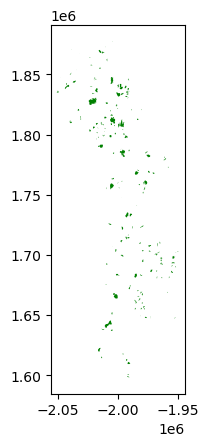

In [60]:
# try plotting them if needed
vl_sample.plot(color='green')

### Google Earth Engine - MODIS LAI product operations
###### product guide MODIS  [MODIS-LAI](https://lpdaac.usgs.gov/documents/624/MOD15_User_Guide_V6.pdf)

In [20]:
# open again the shape file for image downloads
ads_sample = gpd.read_file('./output/shapes/ads_sample_rand.shp')

In [21]:
# this should overide cycles from the beginig; keep commented otherwise
ads_sample = ads_sample[922:]
ads_sample.head()

,OBJECTID,HOST_CODE,HOST,DCA_CODE,DCA_COMMON,DAMAGE_TYP,DAMAGE_T_1,PERCENT_AF,PERCENT__1,ACRES,SURVEY_YEA,id,geometry
922,301266.0,122.0,ponderosa pine,11002,western pine beetle,2,Mortality,1.0,Very Light (1-3%),61.06,2018,923,"POLYGON ((-118.69646 35.96569, -118.69598 35.9..."
923,304957.0,20.0,California red fir,11050,fir engraver,2,Mortality,1.0,Very Light (1-3%),403.18,2019,924,"POLYGON ((-118.32484 36.26326, -118.32283 36.2..."
924,319865.0,20.0,California red fir,11050,fir engraver,2,Mortality,1.0,Very Light (1-3%),442.53,2022,925,"POLYGON ((-118.39025 35.87323, -118.39111 35.8..."
925,308620.0,113.0,limber pine,11006,mountain pine beetle,2,Mortality,1.0,Very Light (1-3%),64.18,2019,926,"POLYGON ((-118.91448 37.34688, -118.91442 37.3..."
926,304925.0,20.0,California red fir,11050,fir engraver,2,Mortality,1.0,Very Light (1-3%),36.06,2019,927,"POLYGON ((-118.13532 36.28523, -118.13530 36.2..."


In [59]:
# This cell is only for mitigating non downloading during API operations

# see folder contain data
available = os.listdir('./output/composite')
available = [int(item) for item in available if item != '.DS_Store']

# create a number list
num_list = [item for item in range(1, 1001)]
#  create a missing list
missing_list = list(set(num_list) - set(available))

# open again the shape file for image downloads
ads_sample = gpd.read_file('./output/shapes/ads_sample_rand.shp')
ads_sample = ads_sample[['id', 'geometry']]
# this should overide cycles from the beginig; keep commented otherwise
#ads_sample = ads_sample[922:]
ads_sample.head()
# take the slice not having images
ads_sample = ads_sample[ads_sample['id'].isin(missing_list)]
ads_sample.head()

,id,geometry
1,2,"POLYGON ((-119.58875 37.43853, -119.58867 37.4..."
2,3,"POLYGON ((-118.63373 35.82422, -118.63381 35.8..."
3,4,"POLYGON ((-119.53972 37.44700, -119.53858 37.4..."
4,5,"POLYGON ((-119.19005 37.48655, -119.19012 37.4..."
11,12,"POLYGON ((-118.85538 36.61752, -118.85466 36.6..."


### for single polygon - start from here

In [11]:
#### This cell just overide above shape files
#ads_sample = gpd.read_file('./colorado_input/klamath_EC_boundary.shp')
ads_sample = gpd.read_file('./input/Southern_Sierra.shp')

ads_sample = ads_sample.to_crs('EPSG:4326')
print(ads_sample.crs)
ads_sample['id'] = 1
print(ads_sample)

EPSG:4326
      subregion    Shape_Leng    Shape_Area  Transpar  \
0  South Sierra  1.240197e+06  2.372661e+10        50   

                                            geometry  id  
0  POLYGON ((-119.30084 37.76827, -119.30059 37.7...   1  


In [15]:
# time window # permemant mask
start_dt = '2000-05-01'
end_dt   = '2023-12-31'

# short terms
start_dt = '2013-08-01'
#end_dt   = '2020-07-05'

In [16]:
# Define the function to create the cloud mask and apply it
def apply_cloud_mask(image, quality_band):
    # Define bitmasks for each quality flag
    CLOUDSTATE_MASK = 0b00011000

    # Extract the cloud state bitfield using bitwise AND
    cloud_state = image.select(quality_band).bitwiseAnd(CLOUDSTATE_MASK).rightShift(3)

    # Create a cloud mask for clouds only
    cloud_mask = cloud_state.eq(1)

    # Apply the cloud mask to the original image
    masked_image = image.updateMask(cloud_mask.Not())
    masked_image = image.where(cloud_mask, 0).where(cloud_mask.Not(), image)

    return masked_image

#### Downloading without creating composite images

In [17]:
for index, row in ads_sample.iterrows():
    # Extract corner coordinates
    corners = list(row['geometry'].exterior.coords)
    new_polygon = Polygon(corners)

    # create ee geometry
    #aoi  = ee.Geometry.Polygon(new_polygon)
    aoi  = ee.Geometry.Polygon([list(coord) for coord in corners])
    modis_collection = ee.ImageCollection("MODIS/061/MOD15A2H").filterBounds(aoi).filterDate(start_dt, end_dt)
    # summer collection
    summer_collection = modis_collection.filter(ee.Filter.calendarRange(6, 8, 'month'))

    # QC band name
    quality_band_name = 'FparLai_QC' ###############
    # cloud masking
    modis_lai_masked = summer_collection.map(lambda img:apply_cloud_mask(img, quality_band_name))################

    # images to a list
    image_list = modis_lai_masked .toList(modis_lai_masked .size())
    # take image list and gothrough each of them for download

    # create folder for images
    ads_id = row['id']
    folder_path  = './output/SN_box_images/'+str(ads_id)
    print(ads_id)
    # create folders
    try:
        os.makedirs(folder_path)
    except:
        print('Folder in place already')
    # number of images in collection for aoi

    num_images = modis_lai_masked.size().getInfo()

    for item in range(0, num_images):
        # take images
        filter_image = ee.Image(image_list.get(item))
        # take band
        filter_band = filter_image.select(['Lai_500m'])
        # clip to aoi
        filter_band = filter_band.clip(aoi)#.unmask()
        # image name
        im_name = str(filter_band.get('system:index').getInfo())
        #print(im_name)
        # take url
        try:
            url = filter_band.getDownloadURL({'scale':500,
                                                    'filePerBand':False, 
                                                    'region':aoi,
                                                    'crs':'EPSG:26911',
                                                    #'dataType': 'float64', 
                                                    'maxPixels': 1e13})
            #print(url)
            r = requests.get(url)
            with open(folder_path+'/'+im_name+'.zip', 'wb') as f:
                f.write(r.content)
        except:
            print('no images avialable')
            continue
        # extract the zipfile here
        zip_file = glob.glob('./output/SN_box_images/'+str(ads_id)+'/*zip')
        try:
            zf = ZipFile(zip_file[0])
            zf.extractall('./output/SN_box_images/'+str(ads_id))
            os.remove(zip_file[0])
        except BadZipfile:
            print()
            os.remove(zip_file[0])
                  

1
Folder in place already


#### create annual composite images for summer months ; Now have ddiffferent code to do that

In [145]:
# ...

for index, row in ads_sample.iterrows():
    # Extract corner coordinates
    corners = list(row['geometry'].exterior.coords)
    new_polygon = Polygon(corners)

    # create ee geometry
    aoi = ee.Geometry.Polygon([list(coord) for coord in corners])
    modis_collection = ee.ImageCollection("MODIS/061/MOD15A2H").filterBounds(aoi).filterDate(start_dt, end_dt)
    
    # QC band name
    quality_band_name = 'FparLai_QC'
    
    # Create empty ImageCollection to store annual composites
    annual_composites = ee.ImageCollection([])

    # Iterate over years
    for year in range(2019, 2023):
        # Filter by year
        year_collection = modis_collection.filter(ee.Filter.calendarRange(year, year, 'year'))
        
        # Filter summer months
        summer_collection = year_collection.filter(ee.Filter.calendarRange(6, 8, 'month'))
        
        # Cloud masking
        modis_lai_masked = summer_collection.map(lambda img: apply_cloud_mask(img, quality_band_name))
        

        # Create composite for the year
        composite_image = modis_lai_masked.reduce(ee.Reducer.median())

        # Add the composite to the collection
        annual_composites = annual_composites.merge(composite_image)

        # images to a list
    image_list = annual_composites.toList(annual_composites.size())
    # take image list and gothrough each of them for download

    # create folder for images
    ads_id = row['id']
    folder_path  = './output/images/'+str(ads_id)
    print(folder_path)
    # create folders
    try:
        os.makedirs(folder_path)
    except:
        print('Folder in place already')
    # number of images in collection for aoi
    num_images = annual_composites.size().getInfo()
    for item in range(0, num_images):
        # take images
        filter_image = ee.Image(image_list.get(item))
        # take band
        filter_band = filter_image.select(['Lai_500m_median'])
        # clip to aoi
        filter_band = filter_band.clip(aoi)#.unmask()
        # image name
        im_name = str(filter_band.get('system:index').getInfo())

        #print(im_name)
        # take url
        try:
            url = filter_band.getDownloadURL({'scale':500,
                                                    'filePerBand':False, 
                                                    'region':aoi,
                                                    'crs':'EPSG:26911', 
                                                    'maxPixels': 1e13})
            #print(url)
            r = requests.get(url)
            with open(folder_path+'/'+im_name+'.zip', 'wb') as f:
                f.write(r.content)
        except:
            print('no images avialable')
        # extract the zipfile here
        zip_file = glob.glob('./output/images/'+str(ads_id)+'/*zip')
        zf = ZipFile(zip_file[0])
        zf.extractall('./output/images/'+str(ads_id))
        # remove zipfile
        os.remove(zip_file[0])



./output/images/281
Folder in place already
./output/images/282
Folder in place already


In [141]:
annual_composites

In [146]:
image_list

In [51]:
### overide operations only:: not a regular part of the calculations

available = os.listdir('./output/composite')
available = [int(item) for item in available if item != '.DS_Store']
print(available)
print(len(available))

num_list = [item for item in range(1, 1001)]
print(num_list)
print(len(num_list))

missing_list = list(set(num_list) - set(available))

print(missing_list)
print(len(missing_list))

[797, 909, 135, 307, 763, 551, 61, 95, 338, 936, 556, 764, 300, 132, 59, 790, 931, 569, 92, 66, 336, 938, 104, 560, 752, 594, 907, 309, 799, 50, 68, 593, 755, 567, 103, 331, 57, 900, 558, 168, 954, 391, 533, 701, 365, 157, 739, 953, 150, 362, 706, 534, 998, 396, 159, 965, 32, 991, 730, 502, 166, 354, 192, 996, 398, 35, 708, 962, 195, 353, 161, 505, 737, 566, 754, 330, 102, 592, 69, 901, 559, 56, 595, 105, 939, 337, 753, 561, 51, 798, 308, 906, 791, 58, 765, 557, 133, 301, 67, 930, 93, 568, 306, 134, 908, 550, 762, 796, 94, 937, 339, 60, 709, 963, 399, 997, 34, 160, 352, 736, 504, 194, 33, 990, 964, 158, 193, 503, 731, 355, 167, 738, 952, 397, 999, 363, 151, 535, 707, 955, 169, 700, 532, 156, 364, 390, 686, 818, 216, 672, 440, 229, 827, 447, 675, 211, 681, 820, 478, 227, 829, 471, 643, 485, 816, 218, 688, 482, 644, 476, 220, 811, 449, 845, 280, 422, 610, 274, 628, 842, 273, 617, 425, 889, 287, 874, 880, 621, 413, 245, 887, 289, 619, 873, 242, 414, 626, 477, 645, 221, 483, 810, 448, 484,

In [53]:
# see folder contain data
available = os.listdir('./output/composite')
available = [int(item) for item in available if item != '.DS_Store']

# create a number list
num_list = [item for item in range(1, 1001)]
#  create a missing list
missing_list = list(set(num_list) - set(available))

# open again the shape file for image downloads
ads_sample = gpd.read_file('./output/shapes/ads_sample_rand.shp')
ads_sample = ads_sample[['id', 'geometry']]
# this should overide cycles from the beginig; keep commented otherwise
#ads_sample = ads_sample[922:]
ads_sample.head()
# take the slice not having images
ads_slice = ads_sample[ads_sample['id'].isin(missing_list)]
ads_slice.head()

257

In [42]:
ads_sample.head()

,id,geometry
0,1,"POLYGON ((-119.33235 37.38217, -119.33231 37.3..."
1,2,"POLYGON ((-119.58875 37.43853, -119.58867 37.4..."
2,3,"POLYGON ((-118.63373 35.82422, -118.63381 35.8..."
3,4,"POLYGON ((-119.53972 37.44700, -119.53858 37.4..."
4,5,"POLYGON ((-119.19005 37.48655, -119.19012 37.4..."
